In [386]:
from sqlalchemy import create_engine, func
from sqlalchemy.orm import sessionmaker
import sys
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap, TyreRaceData, Team, DriverTeamSession, TeamCircuitStats

import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from itertools import product

# Initialize database connection
global db_session
engine, db_session = init_db()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [387]:
import pandas as pd
from sqlalchemy.orm import joinedload

def get_race_df(year, circuit):
	race_session = (db_session.query(Session)
					.join(RacingWeekend, Session.weekend_id == RacingWeekend.racing_weekend_id)
					.join(Circuit, RacingWeekend.circut_id == Circuit.circuit_id)
					.filter(
						RacingWeekend.year == year,
						Circuit.circuit_name == circuit,
						Session.session_type == 'Race'
					)
					.first())

	# Fetch all laps for this session, ordered by lap number and position
	laps = (db_session.query(Lap)
			.options(joinedload(Lap.driver))
			.filter(Lap.session_id == race_session.session_id)
			.order_by(Lap.lap_num, Lap.position)
			.all())

	# Convert to DataFrame
	laps_data = []
	for lap in laps:
		laps_data.append({
			'lap_num': lap.lap_num,
			'position': lap.position,
			'driver_name': lap.driver.driver_name,
			'driver_number': lap.driver.driver_num,
			'lap_time': lap.lap_time,
			'tyre': lap.tyre,
			'tyre_laps': lap.tyre_laps,
			'pit': lap.pit,
		})

	df = pd.DataFrame(laps_data)

	return df
def race_df_extra_info(df):
	# Ensure DataFrame is sorted
	df.sort_values(by=['lap_num', 'position'], inplace=True)

	# ------------------------------------------------------------------------------ 
	# STEP 1: Calculate cumulative race time for each driver up to each lap
	# ------------------------------------------------------------------------------ 
	df["cumulative_time"] = df.groupby("driver_name")["lap_time"].cumsum()

	# ------------------------------------------------------------------------------ 
	# STEP 2: Find the car ahead's cumulative time for each lap
	# ------------------------------------------------------------------------------ 
	# Get car ahead's cumulative time (car immediately ahead in position for each lap)
	df["front_cumulative_time"] = df.groupby("lap_num")["cumulative_time"].shift(1)

	# ------------------------------------------------------------------------------ 
	# STEP 3: Calculate gap to car ahead (cumulative difference)
	# ------------------------------------------------------------------------------ 
	# This gap is calculated only for drivers who are not in the lead position (position > 1)
	df["gap"] = df["cumulative_time"] - df["front_cumulative_time"]
	df["gap"] = df["gap"].fillna(0)  # Leader has no car ahead, so gap is 0

	# ------------------------------------------------------------------------------ 
	# STEP 4: Calculate tyre difference (compared to car immediately ahead in THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_tyre"] = df.groupby("lap_num")["tyre"].shift(1)
	df["tyre_diff"] = df["front_tyre"] - df["tyre"]
	df["tyre_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# ------------------------------------------------------------------------------ 
	# STEP 4: Calculate tyre age difference (compared to car immediately ahead in THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_laps"] = df.groupby("lap_num")["tyre_laps"].shift(1)
	df["tyre_age_diff"] = df["front_laps"] - df["tyre_laps"]
	df["tyre_age_diff"] = df["tyre_diff"].fillna(0)  # Leader has no car ahead

	# ------------------------------------------------------------------------------ 
	# STEP 5: Calculate DRS availability (within 1s of car ahead IN THIS LAP)
	# ------------------------------------------------------------------------------ 
	df["front_lap_time"] = df.groupby("lap_num")["lap_time"].shift(1)
	df["drs_available"] = (df["lap_time"] - df["front_lap_time"]).abs() <= 1
	df["drs_available"] = df["drs_available"] & (df["position"] > 1)  # Leader can't have DRS

	# ------------------------------------------------------------------------------ 
	# Cleanup and final sorting
	# ------------------------------------------------------------------------------ 
	df = df.drop(columns=["front_cumulative_time", "front_tyre", "front_lap_time"])
	df["gap"] = df["gap"].round(3)  # Round to 3 decimal places
	df = df.sort_values(["lap_num", "position"])



	# Create target variable (1 if position improved next lap, 0 otherwise)
	df['next_position'] = df.groupby('driver_name')['position'].shift(-1)
	df['overtake'] = ((df['next_position'] < df['position']) | 
					(df['next_position'].isna())).astype(int)


	# df['tyre_age_diff'] = df.groupby('driver_name')['tyre_laps'].diff().fillna(0)

	# Cleanup
	df = df.dropna(subset=['next_position'])

	return df

df_2023 = get_race_df(2023, "Sakhir")
df_2023 = race_df_extra_info(df_2023)

# df_2023

In [388]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight

# Define features and target
features = [
	'gap',
	'tyre_diff',
	'tyre_age_diff',
	'drs_available',
	'lap_num',
	'pit',
	'cumulative_time'
]
X = df_2023[features]
y = df_2023['overtake']

# Handle missing values
X = X.fillna(X.mean())

sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# Base model
gbc = GradientBoostingClassifier(
	n_estimators=200,
	learning_rate=0.05,
	max_depth=3,
	subsample=0.8,
	random_state=42
)


# # Calibrate for better probabilities
model = CalibratedClassifierCV(gbc, method='isotonic', cv=3)

# # Train on all data
model.fit(X, y, sample_weight=sample_weights)

# from lightgbm import LGBMClassifier

# lgbm = LGBMClassifier(
# 	n_estimators=100,
# 	learning_rate=0.1,
# 	max_depth=3,
# 	subsample=0.8,
# 	random_state=42
# )
# model = CalibratedClassifierCV(lgbm, method='isotonic', cv=3)
# model.fit(X, y, sample_weight=sample_weights)

# ------------------------------------------------------------------------------ 
# Step 3: Create a prediction function
# ------------------------------------------------------------------------------ 

feature_means = X.mean()

def predict_overtake(new_race_df):
	# Select the same features used during training
	X_new = new_race_df[features]
	
	# Handle missing values (if any)
	X_new = X_new.fillna(feature_means)
	
	# Make predictions using the trained model
	new_race_df['predicted_overtake'] = model.predict(X_new)
	
	return new_race_df

XGBClassifier could also be good

In [389]:
from sklearn.metrics import accuracy_score, classification_report

# Load the 2023 race data


# Predict overtakes using the rule-based function
new_race_df = predict_overtake(df_2023)

# Calculate accuracy
actual_overtakes = new_race_df['overtake']
predicted_overtakes = new_race_df['predicted_overtake']
accuracy = accuracy_score(actual_overtakes, predicted_overtakes)
print(f"Accuracy: {accuracy:.3f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(
	actual_overtakes,
	predicted_overtakes,
	target_names=['No Overtake', 'Overtake']
))

Accuracy: 0.729

Classification Report:
              precision    recall  f1-score   support

 No Overtake       0.92      0.75      0.82       883
    Overtake       0.30      0.62      0.40       152

    accuracy                           0.73      1035
   macro avg       0.61      0.69      0.61      1035
weighted avg       0.83      0.73      0.76      1035



In [390]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Function Definitions
def correct_fuel_effect(df, max_lap=None, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Find the maximum number of laps completed by any driver in the race
	if max_lap is None:
		max_lap = df['lap_num'].max()

	# Group by driver to process each driver's laps individually
	def _correct_fuel_for_driver(driver_df):
		# Make sure we modify the original DataFrame using .loc to avoid SettingWithCopyWarning
		driver_df.loc[:, 'fuel_weight'] = max_fuel_kg - (driver_df['lap_num'] - 1) * (max_fuel_kg / max_lap)
		driver_df.loc[:, 'fuel_correction'] = driver_df['fuel_weight'] * fuel_effect_per_kg
		driver_df.loc[:, 'fuel_corrected_lap_time'] = driver_df['lap_time'] - driver_df['fuel_correction']
		return driver_df

	# Apply the correction to each driver's laps using groupby and avoid deprecated behavior with group_keys=False
	df = df.groupby('driver_number', group_keys=False)[df.columns].apply(_correct_fuel_for_driver).reset_index(drop=True)
	return df


def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_number'].unique():
		driver_data = df[df['driver_number'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df

def remove_laps_outside_percent(df, percentage=5):
	# Group by driver and apply the filtering logic to each driver's laps
	def _filter_driver_laps(driver_df):
		# Calculate the threshold based on the fastest lap time for the driver
		fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
		threshold = fastest_lap_time * (1 + percentage / 100)

		# Remove laps not within the specified percentage of the fastest lap time
		driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= threshold]

		return driver_df

	# Apply the filtering logic to each driver's laps
	df = df.groupby('driver_number')[df.columns].apply(_filter_driver_laps).reset_index(drop=True)

	return df

def normalise_lap_times(df):
	# Group by driver and calculate the fastest lap time for each driver
	df['fastest_lap_time'] = df.groupby('driver_number')['fuel_corrected_lap_time'].transform('min')

	# Normalise lap times by subtracting the fastest lap time
	df['normalised_lap_time'] = df['fuel_corrected_lap_time'] - df['fastest_lap_time']

	# Drop the fastest_lap_time as it's no longer needed
	df = df.drop(columns=['fastest_lap_time'])

	return df

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def get_tyre_deg(df):
	# Normalize lap times
	df = assign_stint_numbers(df)
	df = correct_fuel_effect(df)
	df = remove_laps_outside_percent(df)
	df = normalise_lap_times(df)

	# Define minimum laps required for each tyre type
	min_laps_by_tyre = {
		1: 3,  # Tyre Type 1 (e.g., Soft)
		2: 5,  # Tyre Type 2 (e.g., Medium)
		3: 7   # Tyre Type 3 (e.g., Hard)
	}

	# Dictionary to store tyre coefficients for each driver
	driver_tyre_coefficients = {}

	# Process each driver
	for driver in df['driver_number'].unique():
		# Filter data for the current driver
		df_driver = df[df['driver_number'] == driver]
		
		# Dictionary to store coefficients for this driver
		driver_coeffs = {}
		
		# Group by tyre type
		for tyre in df_driver['tyre'].unique():
			tyre_data = df_driver[df_driver['tyre'] == tyre]
			
			# List to store coefficients for this tyre type
			tyre_coefficients = []
			
			# Group by stint to handle multiple stints with the same tyre type
			for stint, stint_data in tyre_data.groupby('stint'):
				# Check if the stint meets the minimum lap requirement for the tyre type
				min_laps = min_laps_by_tyre.get(tyre, 0)  # Default to 0 if tyre type not in dictionary
				if len(stint_data) < min_laps:
					continue
				
				# Fit a polynomial of degree 2
				x = stint_data['tyre_laps'].values.reshape(-1, 1)  # Tyre laps as x-axis
				y = stint_data['normalised_lap_time'].values      # Normalized lap times as y-axis
				poly = PolynomialFeatures(degree=2)
				x_poly = poly.fit_transform(x)
				model = LinearRegression()
				model.fit(x_poly, y)
				
				# Store the coefficients (a, b, c) for the polynomial ax^2 + bx + c
				coefficients = [model.coef_[2], model.coef_[1], model.intercept_]  # [a, b, c]
				tyre_coefficients.append(coefficients)
			
			# Average coefficients for this tyre type (if there are any)
			if tyre_coefficients:
				driver_coeffs[tyre] = np.mean(tyre_coefficients, axis=0).tolist()
		
		# Store the driver's coefficients
		driver_tyre_coefficients[driver] = driver_coeffs

	# Step 2: Fallback to global averages if a driver is missing tyre types
	# Calculate global averages for each tyre type
	global_tyre_coefficients = {}
	for tyre in min_laps_by_tyre.keys():
		all_coeffs = [
			driver_coeffs[tyre]
			for driver_coeffs in driver_tyre_coefficients.values()
			if tyre in driver_coeffs
		]
		if all_coeffs:
			global_tyre_coefficients[tyre] = np.mean(all_coeffs, axis=0).tolist()

	# Fill in missing tyre types for each driver
	for driver, driver_coeffs in driver_tyre_coefficients.items():
		for tyre in min_laps_by_tyre.keys():
			if tyre not in driver_coeffs and tyre in global_tyre_coefficients:
				driver_coeffs[tyre] = global_tyre_coefficients[tyre]

	return driver_tyre_coefficients

# deg_2023 = (get_tyre_deg(df_2023))


In [391]:
def extract_driver_strategies(race_df):

	# Initialize the dictionary to store strategies
	driver_strategies = {}

	# Group the data by driver
	for driver in race_df["driver_number"].unique():
		# Filter data for the current driver
		driver_data = race_df[race_df["driver_number"] == driver]
		
		# Get the starting tyre (tyre used on lap 1)
		starting_tyre = driver_data[driver_data["lap_num"] == 1]["tyre"].values[0]
		
		# Extract pit stop laps and tyres
		pits = []
		for _, row in driver_data.iterrows():
			if row["pit"]:  # Check if a pit stop occurred
				pit_lap = row["lap_num"]
				tyre = row["tyre"]
				pits.append((pit_lap, tyre))
		
		# Store the strategy in the dictionary
		driver_strategies[driver] = {
			"starting_tyre": starting_tyre,
			"pits": pits
		}

	return driver_strategies

In [392]:
def setup_race_data(race_df):
    # Extract tyre degradation curves
    driver_tyre_coefficients = get_tyre_deg(race_df)
    
    # Precompute driver strategies
    driver_strategies = extract_driver_strategies(race_df)
    print(driver_strategies)
    # Correct fuel effects in the race data
    max_laps = race_df["lap_num"].max()
    race_df = correct_fuel_effect(race_df, max_lap=max_laps)

    # Precompute base lap times and driver names
    drivers = race_df["driver_number"].unique()
    base_laptimes = {
        driver: race_df[race_df["driver_number"] == driver]["fuel_corrected_lap_time"].min()
        for driver in drivers
    }
    driver_names = {
        driver: race_df[race_df["driver_number"] == driver]["driver_name"].iloc[0]
        for driver in drivers
    }

    # Initialize positions based on cumulative times at lap 1
    initial_cumulative_times = {
        driver: race_df[(race_df["driver_number"] == driver) & (race_df["lap_num"] == 1)]["cumulative_time"].values[0]
        for driver in drivers
    }
    positions = {
        driver: rank for rank, (driver, _) in enumerate(
            sorted(initial_cumulative_times.items(), key=lambda x: x[1]), start=1
        )
    }

    # Return precomputed data as a dictionary
    return {
        "driver_tyre_coefficients": driver_tyre_coefficients,
        "driver_strategies": driver_strategies,
        "race_df": race_df,
        "max_laps": max_laps,
        "drivers": drivers,
        "base_laptimes": base_laptimes,
        "driver_names": driver_names,
        "initial_positions": positions
    }

import pandas as pd

import pandas as pd

def post_race_sim(precomputed_data, given_driver=None, simulated_strategy=None):
    # Extract precomputed data
    driver_tyre_coefficients = precomputed_data["driver_tyre_coefficients"]
    driver_strategies = precomputed_data["driver_strategies"]
    max_laps = precomputed_data["max_laps"]
    drivers = precomputed_data["drivers"]
    base_laptimes = precomputed_data["base_laptimes"]
    driver_names = precomputed_data["driver_names"]
    initial_positions = precomputed_data["initial_positions"]

    # Precompute fuel corrections for all laps
    max_fuel_kg = 110
    fuel_effect_per_kg = 0.03
    fuel_corrections = {
        lap: (max_fuel_kg - (lap - 1) * (max_fuel_kg / max_laps)) * fuel_effect_per_kg
        for lap in range(1, max_laps + 1)
    }

    # Initialize variables
    cumulative_times = {driver: 0 for driver in drivers}
    current_tyres = {driver: None for driver in drivers}
    stint_lengths = {driver: 0 for driver in drivers}
    consecutive_laps_within_2_seconds = {driver: 0 for driver in drivers}
    positions = initial_positions.copy()
    simulated_data = []

    # Simulate the race lap by lap
    for lap in range(1, max_laps + 1):
        lap_data = []  # Temporary storage for this lap's data
        
        for driver in drivers:
            # Determine if this is the given driver with a simulated strategy
            is_given_driver = (driver == given_driver)
            if is_given_driver and simulated_strategy:
                # Parse the simulated strategy
                pit_laps, tyre_sequence = simulated_strategy
                strategy = {
                    "starting_tyre": tyre_sequence[0],  # First tyre in the sequence
                    "pits": list(zip(pit_laps, tyre_sequence[1:]))  # Pair pit laps with subsequent tyres
                }
            else:
                # Use the default strategy for other drivers
                strategy = driver_strategies[driver]
            
            # Get the current tyre and update stint length
            if lap == 1:
                # Set starting tyre
                current_tyres[driver] = strategy["starting_tyre"]
            stint_lengths[driver] += 1
            
            # Check if it's a pit lap
            pits = strategy["pits"] if not is_given_driver else list(zip(pit_laps, tyre_sequence[1:]))
            pit_laps_set = {pit_lap for pit_lap, _ in pits}  # Precompute set for fast lookup
            if lap in pit_laps_set:
                # Add pit stop penalty and switch tyre
                cumulative_times[driver] += 20  # Pit stop penalty
                stint_lengths[driver] = 1  # Reset stint length
                current_tyres[driver] = next(tyre for pit_lap, tyre in pits if pit_lap == lap)
            
            # Get tyre degradation coefficients for the current tyre type
            deg_curve = driver_tyre_coefficients[driver].get(current_tyres[driver], [])
            a, b, c = deg_curve if deg_curve else [0, 0, 0]  # Default to no degradation if curve missing
            
            # Predict lap time using tyre degradation model and base lap time
            lap_time = base_laptimes[driver] + (a * stint_lengths[driver]**2 + b * stint_lengths[driver] + c)
            
            # Add fuel effect
            lap_time += fuel_corrections[lap]
            
            # Update cumulative time
            cumulative_times[driver] += lap_time
            
            # Store temporary data for this lap
            lap_data.append({
                "lap_num": lap,
                "driver_name": driver_names[driver],
                "driver_number": driver,
                "cumulative_time": cumulative_times[driver],
                "position": positions[driver],  # Use the current position
                "lap_time": lap_time,
                "tyre": current_tyres[driver],
                "tyre_laps": stint_lengths[driver],
                "pit": lap in pit_laps_set,
                "overtake": False  # Placeholder, will update later
            })
        
        # Sort drivers by cumulative time to determine positions
        lap_data.sort(key=lambda x: x["cumulative_time"])
        for rank, entry in enumerate(lap_data, start=1):
            driver = entry["driver_number"]
            positions[driver] = rank
            entry["position"] = rank
        
        # Simulate overtakes
        for i, row in enumerate(lap_data):
            driver = row['driver_number']
            position = row['position']
            
            # Skip if the driver is in first place (no one to overtake)
            if position == 1:
                continue
            
            # Find the driver ahead
            driver_ahead = lap_data[i - 1]
            gap = cumulative_times[driver] - cumulative_times[driver_ahead['driver_number']]
            row['gap'] = gap
            
            if gap <= 2:
                consecutive_laps_within_2_seconds[driver] += 1
                
                # Determine DRS availability
                drs_available = gap <= 1.0  # DRS is available if within 1 second
                
                # Prepare features for overtake prediction
                features_dict = {
                    'gap': gap,
                    'tyre_diff': current_tyres[driver] - current_tyres[driver_ahead['driver_number']],
                    'tyre_age_diff': stint_lengths[driver] - stint_lengths[driver_ahead['driver_number']],
                    'drs_available': drs_available,
                    'lap_num': lap,
                    'pit': row['pit'],
                    'cumulative_time': cumulative_times[driver]
                }
                features_df = pd.DataFrame([features_dict])
                
                # Predict overtake (placeholder function)
                features_df = predict_overtake(features_df)
                overtake = features_df['predicted_overtake'].values[0]
                
                # Force overtake if within 2 seconds for 4+ consecutive laps
                if consecutive_laps_within_2_seconds[driver] >= 4:
                    overtake = True
                
                # If overtake is successful, swap positions
                if overtake:
                    # Swap cumulative times and positions
                    cumulative_times[driver], cumulative_times[driver_ahead['driver_number']] = (
                        cumulative_times[driver_ahead['driver_number']], cumulative_times[driver]
                    )
                    positions[driver], positions[driver_ahead['driver_number']] = (
                        positions[driver_ahead['driver_number']], positions[driver]
                    )
                    row['overtake'] = True
                else:
                    # Ensure the driver doesn't undercut the driver ahead
                    if cumulative_times[driver] < cumulative_times[driver_ahead['driver_number']]:
                        cumulative_times[driver] = cumulative_times[driver_ahead['driver_number']] + 0.2
            else:
                consecutive_laps_within_2_seconds[driver] = 0
        
        # Append lap data to simulated_data
        simulated_data.extend(lap_data)
    
    # Convert simulated data to a DataFrame
    simulated_df = pd.DataFrame(simulated_data)
    simulated_df.sort_values(by=['lap_num', 'position'], inplace=True)
    
    return simulated_df


precomputed_data = setup_race_data(df_2023)
final_df_ov = post_race_sim(precomputed_data, given_driver=585, simulated_strategy=([10, 34], [1, 2, 1]))

print(final_df_ov[final_df_ov["lap_num"] == final_df_ov["lap_num"].max()])

{np.int64(33): {'starting_tyre': np.int64(1), 'pits': [(15, 1), (37, 3)]}, np.int64(16): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (34, 3)]}, np.int64(11): {'starting_tyre': np.int64(1), 'pits': [(18, 1), (35, 3)]}, np.int64(55): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(44): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (31, 3)]}, np.int64(63): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(14): {'starting_tyre': np.int64(1), 'pits': [(15, 3), (35, 3)]}, np.int64(77): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (30, 3)]}, np.int64(18): {'starting_tyre': np.int64(1), 'pits': [(16, 3), (31, 3)]}, np.int64(4): {'starting_tyre': np.int64(1), 'pits': [(11, 3), (18, 1), (28, 2), (38, 3), (48, 1)]}, np.int64(31): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (16, 3), (33, 3)]}, np.int64(23): {'starting_tyre': np.int64(1), 'pits': [(12, 1), (27, 3), (41, 1)]}, np.int64(45): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (13,

In [393]:
# import pandas as pd

# def post_race_sim(race_df, given_driver, simulated_strategy):
# 	# driver_tyre_coefficients = get_tyre_deg(race_df)

# 	simulated_pit_stops, simulated_tyres = simulated_strategy

# 	max_laps = race_df["lap_num"].max()
# 	drivers = race_df["driver_number"].unique()
# 	cumulative_times = {driver: 0 for driver in drivers}
# 	current_tyres = {driver: None for driver in drivers}
# 	stint_lengths = {driver: 0 for driver in drivers}

# 	strategies = extract_driver_strategies(race_df)

# 	print(strategies)
# 	# Precompute driver strategies
# 	driver_strategies = extract_driver_strategies(race_df)

# 	race_df = correct_fuel_effect(race_df, max_lap=max_laps)


# 	base_laptimes = {}
# 	driver_names = {}
# 	for driver in drivers:
# 		base_time = race_df[race_df["driver_number"] == driver]["fuel_corrected_lap_time"].min()
# 		driver_name = race_df[race_df["driver_number"] == driver]["driver_name"].iloc[0]

# 		driver_names[driver] = driver_name
# 		base_laptimes[driver] = base_time

# 	simulated_data = []


	
# 	# Simulate the race lap by lap
# 	for lap in range(1, max_laps + 1):
# 		lap_data = []  # Temporary storage for this lap's data
		
# 		for driver in drivers:
# 			# Determine if this is the given driver with a simulated strategy
# 			is_given_driver = (driver == given_driver)
# 			strategy = simulated_strategy if is_given_driver else driver_strategies[driver]
			
# 			# Get the current tyre and update stint length
# 			if lap == 1:
# 				# Set starting tyre
# 				current_tyres[driver] = strategy["starting_tyre"]
# 			stint_lengths[driver] += 1
			
# 			# Check if it's a pit lap
# 			pits = strategy["pits"] if not is_given_driver else list(zip(strategy[0], strategy[1]))
# 			if lap in [pit_lap for pit_lap, _ in pits]:
# 				# Add pit stop penalty and switch tyre
# 				cumulative_times[driver] += 20  # Pit stop penalty
# 				stint_lengths[driver] = 1  # Reset stint length
# 				current_tyres[driver] = next(tyre for pit_lap, tyre in pits if pit_lap == lap)
			
# 			# Get tyre degradation coefficients for the current tyre type
# 			deg_curve = driver_tyre_coefficients[driver].get(current_tyres[driver], [])
# 			a, b, c = deg_curve if deg_curve else [0, 0, 0]  # Default to no degradation if curve missing
			
# 			# Predict lap time using tyre degradation model and base lap time
# 			lap_time = base_laptimes[driver] + (a * stint_lengths[driver]**2 + b * stint_lengths[driver] + c)
			
# 			# Add fuel effect
# 			max_fuel_kg = 110
# 			fuel_effect_per_kg = 0.03
# 			fuel_weight = max_fuel_kg - (lap - 1) * (max_fuel_kg / max_laps)
# 			fuel_correction = fuel_weight * fuel_effect_per_kg
# 			lap_time += fuel_correction
			
# 			# Update cumulative time
# 			cumulative_times[driver] += lap_time
			
# 			# Store temporary data for this lap
# 			lap_data.append({
# 				"lap_num": lap,
# 				"driver_name": driver_names[driver],
# 				"driver_number": driver,
# 				"cumulative_time": cumulative_times[driver],
# 				"position": 0,  # Placeholder, will update later
# 				"lap_time": lap_time,
# 				"tyre": current_tyres[driver],
# 				"tyre_laps": stint_lengths[driver],
# 				"pit": lap in [pit_lap for pit_lap, _ in pits],
# 				"overtake": False  # Placeholder, will update later
# 			})
		
# 		# Convert lap_data to a DataFrame for overtaking simulation
# 		lap_df = pd.DataFrame(lap_data)
		
# 		# Sort by cumulative time to determine positions
# 		lap_df['position'] = lap_df['cumulative_time'].rank(method='min').astype(int)
		
# 		# Append lap data to simulated_data
# 		simulated_data.extend(lap_df.to_dict(orient='records'))
	
# 	# Convert simulated data to a DataFrame
# 	simulated_df = pd.DataFrame(simulated_data)
	
# 	# Combine original race_df with simulated_df
# 	final_df = pd.concat([simulated_df], ignore_index=True)
# 	simulated_df.sort_values(by=['lap_num', 'position'], inplace=True)
	
# 	return simulated_df

# final_df = post_race_sim(df_2023, 585, ([10,34], [1,2,1]))

# final_df[final_df["lap_num"] == final_df["lap_num"].max()]

In [394]:
def calculate_position_errors(simulated_df, race_df):
	# Extract the final positions from the original race data
	max_lap = race_df["lap_num"].max()
	actual_final_positions = (
		race_df[race_df["lap_num"] == max_lap]
		.set_index("driver_number")["position"]
		.to_dict()
	)

	# Extract the final positions from the simulated data
	simulated_final_positions = (
		simulated_df[simulated_df["lap_num"] == max_lap]
		.set_index("driver_number")["position"]
		.to_dict()
	)

	# Calculate individual errors for each driver
	errors = {}
	for driver in actual_final_positions.keys():
		actual_pos = actual_final_positions[driver]
		simulated_pos = simulated_final_positions.get(driver, None)
		if simulated_pos is not None:
			errors[driver] = abs(actual_pos - simulated_pos)
		else:
			errors[driver] = None  # Handle missing drivers in the simulation

	# Calculate overall metrics
	valid_errors = [error for error in errors.values() if error is not None]
	mean_error = sum(valid_errors) / len(valid_errors) if valid_errors else None
	total_error = sum(valid_errors) if valid_errors else None

	# Return results as a dictionary
	return {
		"individual_errors": errors,
		"mean_error": mean_error,
		"total_error": total_error
	}

print(calculate_position_errors(final_df_ov, df_2023))
print(calculate_position_errors(final_df, df_2023))

{'individual_errors': {33: 1, 11: 1, 14: 3, 55: 5, 44: 5, 18: 2, 63: 1, 77: 1, 10: 2, 23: 2, 22: 2}, 'mean_error': 2.272727272727273, 'total_error': 25}
{'individual_errors': {33: 0, 11: 0, 14: 3, 55: 1, 44: 0, 18: 5, 63: 1, 77: 5, 10: 0, 23: 2, 22: 5}, 'mean_error': 2.0, 'total_error': 22}


In [397]:
import random

def greedy_strategy_optimization(race_df, given_driver, initial_strategy, max_iterations=50):
    # Precompute reusable data
    precomputed_data = setup_race_data(race_df)
    max_laps = precomputed_data["max_laps"]
    
    # Initialize the best strategy and its performance
    best_strategy = initial_strategy
    precomputed_data = setup_race_data(race_df)
    final_df = post_race_sim(precomputed_data, given_driver, best_strategy)
    best_position = final_df[(final_df["driver_number"] == given_driver) & 
                             (final_df["lap_num"] == max_laps)]["position"].values[0]
    # Run the greedy heuristic algorithm
    for iteration in range(max_iterations):
        # Generate a neighboring strategy by making a small random change
        current_pit_laps, current_tyres = best_strategy
        new_pit_laps = list(current_pit_laps)
        new_tyres = list(current_tyres)
        
        # Randomly modify one pit lap or tyre choice
        if random.random() < 0.5 and len(new_pit_laps) > 0:
            # Modify a pit lap
            idx = random.randint(0, len(new_pit_laps) - 1)
            new_pit_laps[idx] = random.randint(1, max_laps)
            new_pit_laps.sort()  # Ensure pit laps remain sorted
        else:
            # Modify a tyre choice
            idx = random.randint(0, len(new_tyres) - 1)
            new_tyres[idx] = random.choice([1, 2, 3]) 
        
        # Evaluate the new strategy
        new_strategy = (new_pit_laps, new_tyres)
        final_df = post_race_sim(precomputed_data, given_driver, new_strategy)
        new_position = final_df[(final_df["driver_number"] == given_driver) & 
                                (final_df["lap_num"] == max_laps)]["position"].values[0]
        
        # Accept the new strategy if it improves the finishing position
        if new_position < best_position:
            best_strategy = new_strategy
            best_position = new_position
            print(f"Iteration {iteration + 1}: Improved to position {best_position} with strategy {best_strategy}")
        
        # Terminate early if the driver wins the race
        if best_position == 1:
            print("Optimal strategy found: Driver wins the race!")
            break
    
    return best_strategy, best_position

greedy_strategy_optimization(df_2023, 10, ([9, 25, 40], [1,3,3,1]))



{np.int64(33): {'starting_tyre': np.int64(1), 'pits': [(15, 1), (37, 3)]}, np.int64(16): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (34, 3)]}, np.int64(11): {'starting_tyre': np.int64(1), 'pits': [(18, 1), (35, 3)]}, np.int64(55): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(44): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (31, 3)]}, np.int64(63): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(14): {'starting_tyre': np.int64(1), 'pits': [(15, 3), (35, 3)]}, np.int64(77): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (30, 3)]}, np.int64(18): {'starting_tyre': np.int64(1), 'pits': [(16, 3), (31, 3)]}, np.int64(4): {'starting_tyre': np.int64(1), 'pits': [(11, 3), (18, 1), (28, 2), (38, 3), (48, 1)]}, np.int64(31): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (16, 3), (33, 3)]}, np.int64(23): {'starting_tyre': np.int64(1), 'pits': [(12, 1), (27, 3), (41, 1)]}, np.int64(45): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (13,

(([11, 25, 40], [1, 3, 3, 1]), np.int64(10))

{np.int64(33): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (25, 3), (50, 2), (70, 1)]}, np.int64(16): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (16, 2), (48, 3)]}, np.int64(55): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (16, 2), (46, 3)]}, np.int64(44): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (43, 2)]}, np.int64(4): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (42, 3)]}, np.int64(14): {'starting_tyre': np.int64(3), 'pits': [(3, 3), (16, 2), (45, 2)]}, np.int64(27): {'starting_tyre': np.int64(2), 'pits': [(3, 2)]}, np.int64(20): {'starting_tyre': np.int64(3), 'pits': [(1, 3), (2, 2), (3, 3), (35, 3)]}, np.int64(18): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (16, 3), (37, 3), (55, 2)]}, np.int64(10): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (45, 2)]}, np.int64(23): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (42, 3)]}, np.int64(63): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (42, 2)]}, np.int64(31): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (41, 3)]}, np.int64(11): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (26, 2), (51, 3)]}, np.int64(37): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (9, 3), (39, 3)]}, np.int64(81): {'starting_tyre': np.int64(2), 'pits': [(3, 2), (15, 3), (23, 3), (42, 2)]}, np.int64(45): {'starting_tyre': np.int64(2), 'pits': [(1, 2), (3, 2), (3, 2), (13, 3), (15, 3), (38, 2), (44, 3)]}, np.int64(77): {'starting_tyre': np.int64(3), 'pits': [(3, 3), (22, 2), (41, 3)]}, np.int64(22): {'starting_tyre': np.int64(2), 'pits': [(2, 3), (3, 3), (24, 3), (44, 2)]}}


In [413]:
from bayes_opt import BayesianOptimization
import numpy as np

def bayesian_strategy_optimization(race_df, given_driver, initial_strategy, max_iterations=50):
    # Precompute reusable data
    precomputed_data = setup_race_data(race_df)
    max_laps = precomputed_data["max_laps"]
    
    # Define the objective function for Bayesian Optimization
    def objective_function(**kwargs):
        # Parse the arguments into a strategy
        num_pits = len(initial_strategy[0])  # Number of pit stops
        num_tyres = len(initial_strategy[1])  # Number of tyre choices
        
        # Extract pit laps and tyres from kwargs
        pit_laps = sorted([int(kwargs[f"pit_lap_{i}"]) for i in range(num_pits)])
        tyres = [int(kwargs[f"tyre_{i}"]) for i in range(num_tyres)]
        
        # Ensure pit laps are within valid range
        pit_laps = [max(1, min(max_laps, lap)) for lap in pit_laps]
        
        # Ensure tyre choices are valid (1=Hard, 2=Medium, 3=Soft)
        tyres = [max(1, min(3, tyre)) for tyre in tyres]
        
        # Evaluate the strategy
        strategy = (pit_laps, tyres)
        final_df = post_race_sim(precomputed_data, given_driver, strategy)
        position = final_df[(final_df["driver_number"] == given_driver) & 
                            (final_df["lap_num"] == max_laps)]["position"].values[0]
        
        # Minimize finishing position (lower is better)
        return -position  # Negative because BayesianOptimization maximizes by default
    
    # Set up the parameter bounds for Bayesian Optimization
    num_pits = len(initial_strategy[0])  # Number of pit stops
    num_tyres = len(initial_strategy[1])  # Number of tyre choices
    
    pbounds = {}
    for i in range(num_pits):
        pbounds[f"pit_lap_{i}"] = (1, max_laps)  # Pit laps must be within the race
    for i in range(num_tyres):
        pbounds[f"tyre_{i}"] = (1, 3)  # Tyre choices must be 1, 2, or 3
    
    # Initialize the Bayesian Optimizer
    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=pbounds,
        verbose=2,
        random_state=42
    )
    
    # Perform the optimization
    optimizer.maximize(init_points=5, n_iter=max_iterations)
    
    # Extract the best strategy from the optimizer
    best_params = optimizer.max["params"]
    best_pit_laps = sorted([int(best_params[f"pit_lap_{i}"]) for i in range(num_pits)])
    best_tyres = [int(best_params[f"tyre_{i}"]) for i in range(num_tyres)]
    best_strategy = (best_pit_laps, best_tyres)
    
    # Evaluate the best strategy to get the finishing position
    final_df = post_race_sim(precomputed_data, given_driver, best_strategy)
    best_position = final_df[(final_df["driver_number"] == given_driver) & 
                             (final_df["lap_num"] == max_laps)]["position"].values[0]
    
    print(f"Best Strategy: {best_strategy}")
    print(f"Best Finishing Position: {best_position}")
    
    return best_strategy, best_position


initial_strategy = ([14, 34], [1, 1, 3])

# Optimize the strategy for driver 10
best_strategy, best_position = bayesian_strategy_optimization(
    race_df=df_2023,
    given_driver=33,
    initial_strategy=initial_strategy,
    max_iterations=20
)

print(f"Best Strategy: {best_strategy}")
print(f"Best Finishing Position: {best_position}")

{np.int64(33): {'starting_tyre': np.int64(1), 'pits': [(15, 1), (37, 3)]}, np.int64(16): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (34, 3)]}, np.int64(11): {'starting_tyre': np.int64(1), 'pits': [(18, 1), (35, 3)]}, np.int64(55): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(44): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (31, 3)]}, np.int64(63): {'starting_tyre': np.int64(1), 'pits': [(14, 3), (32, 3)]}, np.int64(14): {'starting_tyre': np.int64(1), 'pits': [(15, 3), (35, 3)]}, np.int64(77): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (30, 3)]}, np.int64(18): {'starting_tyre': np.int64(1), 'pits': [(16, 3), (31, 3)]}, np.int64(4): {'starting_tyre': np.int64(1), 'pits': [(11, 3), (18, 1), (28, 2), (38, 3), (48, 1)]}, np.int64(31): {'starting_tyre': np.int64(1), 'pits': [(13, 3), (16, 3), (33, 3)]}, np.int64(23): {'starting_tyre': np.int64(1), 'pits': [(12, 1), (27, 3), (41, 1)]}, np.int64(45): {'starting_tyre': np.int64(1), 'pits': [(12, 3), (13,

{np.int64(4): {np.int64(1): [0.19627795815295668, -3.248217929292899, 14.962616053390903], np.int64(3): [0.10947451790633567, -1.18820297127115, 4.224771546635172], np.int64(2): [0.0671677489177494, -0.43590108225108987, 1.7356857142857283]}, np.int64(10): {np.int64(1): [-0.006622279681103446, 0.2575629390217648, 1.23691758241758], np.int64(3): [0.009678415334665413, -0.06805224150849253, 2.314947002997005], 2: [0.0671677489177494, -0.43590108225108987, 1.7356857142857283]}, np.int64(11): {np.int64(1): [0.020411299388176374, -0.3676389899380812, 2.0895419034719174], np.int64(3): [-0.005529411888924141, 0.20518615225425083, -0.15708013177066715], 2: [0.0671677489177494, -0.43590108225108987, 1.7356857142857283]}, np.int64(14): {np.int64(1): [0.005882617382617042, 0.06992507492508189, 0.741996003995967], np.int64(3): [0.002916830647768506, 0.02130370923330231, 0.7473434218884798], 2: [0.0671677489177494, -0.43590108225108987, 1.7356857142857283]}, np.int64(16): {np.int64(1): [0.058652847

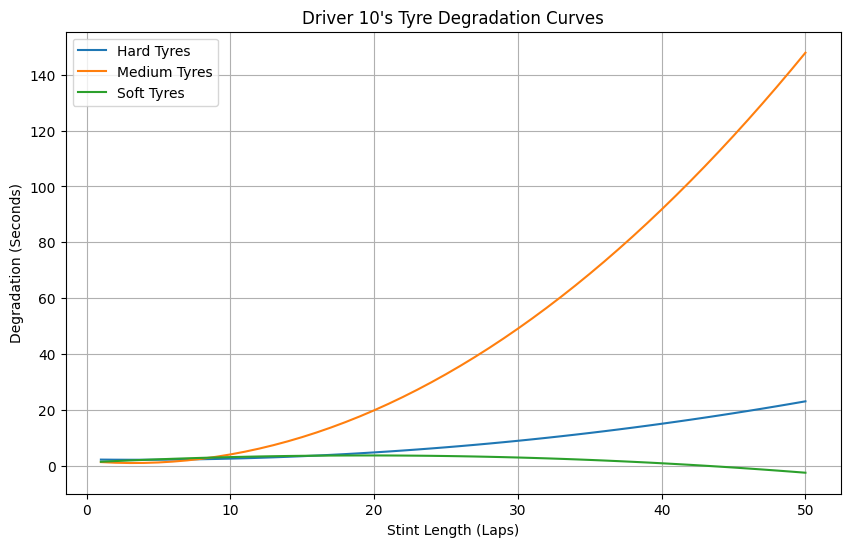

In [409]:
deg_2023 = (get_tyre_deg(df_2023))
print(deg_2023)


import matplotlib.pyplot as plt
import numpy as np

# Extract Driver 10's degradation coefficients
driver_10_deg = {
    1: [0.009678415334665413, -0.06805224150849253, 2.314947002997005],  # Hard
    2: [0.0671677489177494, -0.43590108225108987, 1.7356857142857283],   # Medium
    3: [-0.006622279681103446, 0.2575629390217648, 1.23691758241758]      # Soft
}

# Define a function to calculate degradation
def calculate_degradation(coefficients, stint_length):
    a, b, c = coefficients
    return a * stint_length**2 + b * stint_length + c

# Generate data for plotting
stint_lengths = np.arange(1, 51)  # Assume stints up to 50 laps
degradation_curves = {}

for tyre_type, coefficients in driver_10_deg.items():
    degradation_curves[tyre_type] = [calculate_degradation(coefficients, lap) for lap in stint_lengths]

# Plot the degradation curves
plt.figure(figsize=(10, 6))
for tyre_type, degradation in degradation_curves.items():
    label = "Hard" if tyre_type == 1 else "Medium" if tyre_type == 2 else "Soft"
    plt.plot(stint_lengths, degradation, label=f"{label} Tyres")

# Add labels and legend
plt.title("Driver 10's Tyre Degradation Curves")
plt.xlabel("Stint Length (Laps)")
plt.ylabel("Degradation (Seconds)")
plt.legend()
plt.grid(True)
plt.show()